In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import json
from tqdm import tqdm_notebook
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_absolute_error

In [2]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [3]:
PATH_TO_DATA = 'E:/data/'

In [4]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result

In [5]:
def preprocess(path_to_inp_json_file):
    output_list = []
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file:
        for line in tqdm_notebook(inp_file):
            json_data = read_json_line(line)
            content = json_data['content'].replace('\n', ' ').replace('\r', ' ')
            content_no_html_tags = strip_tags(content)
            output_list.append(content_no_html_tags)
    return output_list

In [6]:
from scipy.sparse import csr_matrix, hstack

In [7]:
%%time
train_raw_content = preprocess(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 
                                                                  'train.json'),)

A Jupyter Widget


Wall time: 10min 54s


In [8]:
%%time
test_raw_content = preprocess(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 
                                                                  'test.json'),)

A Jupyter Widget


Wall time: 6min 14s


In [9]:
import scipy.stats as stats

In [23]:
stats.binom_test([667,14061], p=0.05,alternative="less")

0.004154232582578638

In [24]:
cv = CountVectorizer(max_features=60000)

In [25]:
%%time
X_train = cv.fit_transform(train_raw_content)

Wall time: 4min 11s


In [26]:
%%time
X_test = cv.transform(test_raw_content)

Wall time: 1min 33s


In [27]:
train_target = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_log1p_recommends.csv'), 
                           index_col='id')

In [28]:
y_train = train_target['log_recommends'].values

In [29]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_part = X_train[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_valid =  X_train[train_part_size:, :]
y_valid = y_train[train_part_size:]

In [30]:
from sklearn.linear_model import Ridge

In [31]:
ridge = Ridge(random_state=17)

In [18]:
%%time
ridge.fit(X_train_part, y_train_part);

Wall time: 3min 25s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [19]:
ridge_pred = ridge.predict(X_valid)

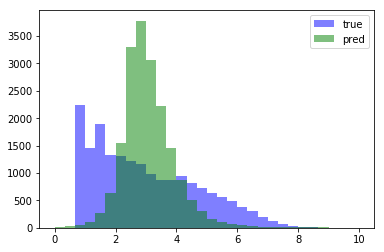

In [20]:
plt.hist(y_valid, bins=30, alpha=.5, color='blue', label='true', range=(0,10));
plt.hist(ridge_pred, bins=30, alpha=.5, color='green', label='pred', range=(0,10));
plt.legend();

In [21]:
valid_mae = mean_absolute_error(y_valid, ridge_pred)
valid_mae, np.expm1(valid_mae)

(1.3063010808364373, 2.6924901979506584)

In [120]:
from xgboost import XGBRegressor

In [24]:
# specify the training parameters 
model = XGBRegressor()
#train the model
model.fit(X_train_part, y_train_part)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [25]:
xgb_pred = model.predict(X_valid)

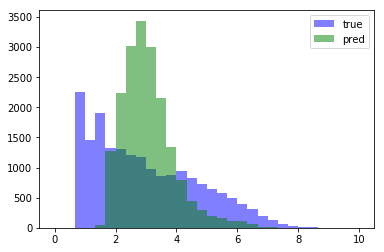

In [26]:
plt.hist(y_valid, bins=30, alpha=.5, color='blue', label='true', range=(0,10));
plt.hist(xgb_pred, bins=30, alpha=.5, color='green', label='pred', range=(0,10));
plt.legend();

In [29]:
valid_mae = mean_absolute_error(y_valid, xgb_pred)
valid_mae, np.expm1(valid_mae)

(1.2530238984294422, 2.5009133739273768)

In [34]:
xgb_pred

array([ 2.77283812,  3.08394289,  2.46486902, ...,  2.55312204,
        3.24657655,  2.93844652], dtype=float32)

In [37]:
np.where(xgb_pred<1)

(array([], dtype=int64),)

In [95]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [96]:
xgb_test_pred = model.predict(X_test)

In [97]:
write_submission_file(prediction=xgb_test_pred, 
                      filename='xgb_test_pred_stopw.csv')

In [148]:
pred_h = xgb_test_pred-np.log(2)
xgb_test_pred_h=pred_h*4.33328/pred_h.mean()

In [149]:
write_submission_file(prediction=xgb_test_pred_h, 
                      filename='xgb_test_pred_h_sw4.csv')

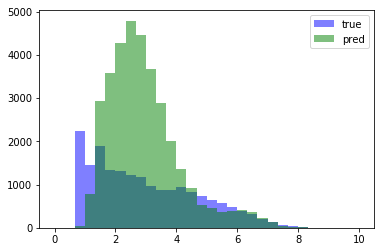

In [129]:
plt.hist(y_valid, bins=30, alpha=.5, color='blue', label='true', range=(0,10));
plt.hist(xgb_test_pred*4.33328/xgb_test_pred.mean()-np.log(4), bins=30, alpha=.5, color='green', label='pred', range=(0,10));
plt.legend();

In [99]:
xgb_pred_h=xgb_pred*4.33328/xgb_pred.mean()

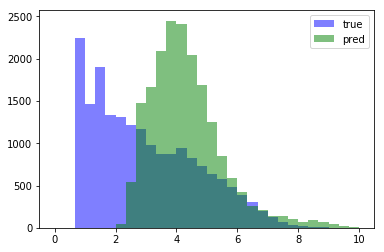

In [115]:
plt.hist(y_valid, bins=30, alpha=.5, color='blue', label='true', range=(0,10));
plt.hist(xgb_pred_h, bins=30, alpha=.5, color='green', label='pred', range=(0,10));
plt.legend();

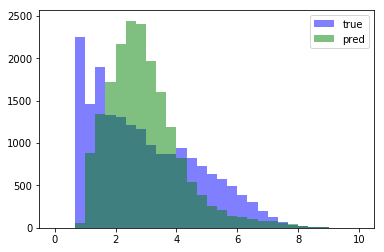

In [127]:
plt.hist(y_valid, bins=30, alpha=.5, color='blue', label='true', range=(0,10));
plt.hist(xgb_pred*4.33328/xgb_pred.mean()-np.log(4), bins=30, alpha=.5, color='green', label='pred', range=(0,10));
plt.legend();

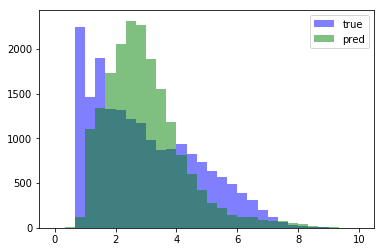

In [145]:
pred = xgb_pred-np.log(3)
plt.hist(y_valid, bins=30, alpha=.5, color='blue', label='true', range=(0,10));
plt.hist(pred*2.9556227666631001/pred.mean(), bins=30, alpha=.5, color='green', label='pred', range=(0,10));
plt.legend();

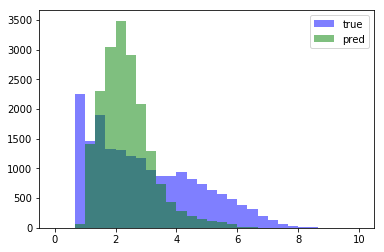

In [121]:
plt.hist(y_valid, bins=30, alpha=.5, color='blue', label='true', range=(0,10));
plt.hist(xgb_pred-np.log(2), bins=30, alpha=.5, color='green', label='pred', range=(0,10));
plt.legend();

In [110]:
xgb_pred.min()-np.log(1)

1.1836833953857422

In [111]:
y_valid.min()

0.69315000000000004

In [118]:
(xgb_pred_h-2+np.log(2)).mean()

3.0264275

In [ ]:
np.zeros_like(y_valid)

In [140]:
valid_mae = mean_absolute_error(y_valid, np.zeros_like(y_valid))
valid_mae

2.9556227666631001

In [32]:
def get_date(path_to_inp_json_file):
    output_list = []
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file:
        for line in tqdm_notebook(inp_file):
       #     print(line)
            json_data = read_json_line(line)
            content = pd.to_datetime(json_data['published']['$date'])
          #  print(content)
            #content_no_html_tags = strip_tags(content)
            output_list.append(content)
          #  return output_list
    return output_list

In [33]:
%%time
dates_train = get_date(os.path.join(PATH_TO_DATA,'train.json'))

A Jupyter Widget


Wall time: 1min 3s


In [34]:
%%time
dates_test = get_date(os.path.join(PATH_TO_DATA,'test.json'))

A Jupyter Widget


Wall time: 1min 18s


In [35]:
df = pd.DataFrame(
    {'date': dates_train,
     'y': y_train
    })

In [46]:
df_test = pd.DataFrame(
    {'date': dates_test
    })

In [36]:
df_common = pd.DataFrame(
    {'date': dates_train+dates_test
    })

In [207]:
df_common.tail()

,date,year,authors
96953,2017-08-21 22:07:44.254,2017,NaN
96954,2018-02-07 00:06:13.758,2018,NaN
96955,2017-12-28 18:00:38.412,2017,NaN
96956,2018-02-07 18:23:17.743,2018,NaN
96957,2018-02-24 19:19:44.956,2018,NaN


In [73]:
df_common.shape

(96958, 1)

In [74]:
df.shape

(62313, 4)

In [47]:
df_test.shape

(34645, 1)

In [37]:
df['year'] = df['date'].apply(lambda ts: ts.year)

In [53]:
df_test['year'] = df_test['date'].apply(lambda ts: ts.year)

In [38]:
df_common['year'] = df_common['date'].apply(lambda ts: ts.year)

In [77]:
pd.get_dummies(df['year']).shape

(62313, 17)

In [78]:
pd.get_dummies(df_common['year']).shape

(96958, 18)

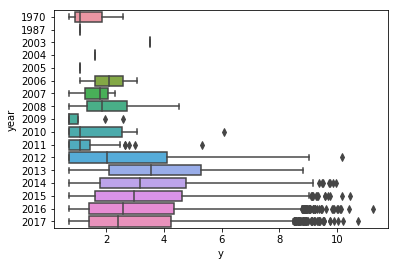

In [44]:
import seaborn as sns
sns.boxplot(y="year", x="y", data=df, orient="h")

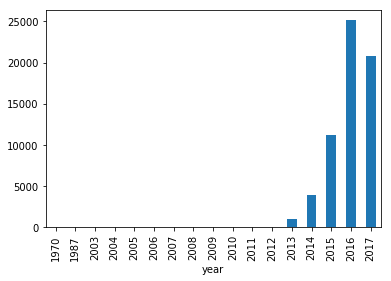

In [46]:
df.groupby(['year'])['y'].count().plot(kind='bar')

plt.show()

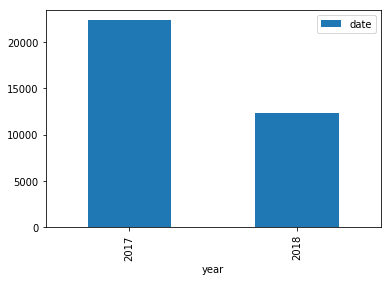

In [151]:
df_test.groupby(['year']).count().plot(kind='bar')

plt.show()

In [87]:
(pd.get_dummies(df_common["year"]))[:df.shape[0]].shape

(62313, 18)

In [84]:
df.shape[0]

62313

In [39]:
X_train_year = csr_matrix(hstack([X_train, 
                             (pd.get_dummies(df_common["year"]))[:df.shape[0]]]))

In [40]:
X_test_year= csr_matrix(hstack([X_test, 
      (pd.get_dummies(df_common["year"]))[df.shape[0]:]]))

In [49]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_year_part = X_train_year[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_year_valid =  X_train_year[train_part_size:, :]
y_valid = y_train[train_part_size:]

In [51]:
%%time
model.fit(X_train_year_part, y_train_part)

Wall time: 3min 25s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [53]:
xgb_year_pred = model.predict(X_year_valid)

In [54]:
valid_mae = mean_absolute_error(y_valid, xgb_year_pred)
valid_mae, np.expm1(valid_mae)

(1.2516975919662823, 2.496273167740513)

In [91]:
%%time
model.fit(X_train_year, y_train)

Wall time: 4min 47s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [92]:
xgb_test_year_pred = model.predict(X_test_year)

In [41]:
def write_submission_file(prediction, filename,
    path_to_sample=os.path.join(PATH_TO_DATA, 'sample_submission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='id')
    
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [94]:
write_submission_file(prediction=xgb_test_year_pred, 
                      filename='xgb_test_year_pred.csv')

In [42]:
df['hour'] = df['date'].apply(lambda ts: ts.hour)

In [48]:
df_test['hour'] = df_test['date'].apply(lambda ts: ts.hour)

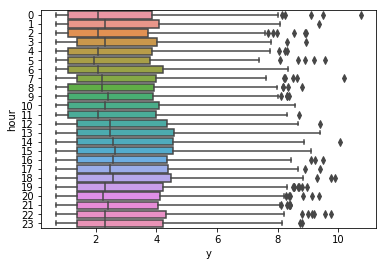

In [313]:
sns.boxplot(y="hour", x="y", data=df[df["year"]>=2017], orient="h")

In [49]:
df['day_of_week'] = df['date'].apply(lambda ts: ts.weekday())

In [50]:
df_test['day_of_week'] = df_test['date'].apply(lambda ts: ts.weekday())

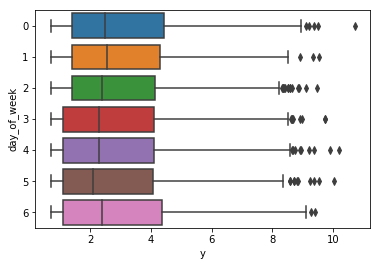

In [317]:
sns.boxplot(y="day_of_week", x="y", data=df[df['y2017']], orient="h")

In [51]:
df['y2017'] = df["year"] == 2017

In [54]:
df_test['y2017'] = df_test["year"] == 2017

In [55]:
df['day_of_week0-2'] = df["day_of_week"] <=2

In [56]:
df_test['day_of_week0-2'] = df_test["day_of_week"] <=2

In [57]:
df['h0-11'] = df["hour"] <=11

In [58]:
df_test['h0-11'] = df_test["hour"] <=11

In [59]:
df['y2017h0-11'] = df['date'].apply(lambda ts: ts.year >=2017 and ts.hour<=11)

In [60]:
df['y2017dw0-2'] = df['date'].apply(lambda ts: ts.year >=2017 and ts.weekday()<=2)

In [61]:
df['month'] = df['date'].apply(lambda ts: ts.month)

In [62]:
df_test['month'] = df_test['date'].apply(lambda ts: ts.month)

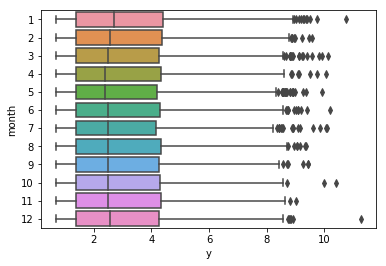

In [310]:
sns.boxplot(y="month", x="y", data=df[df["year"]>=2016], orient="h")

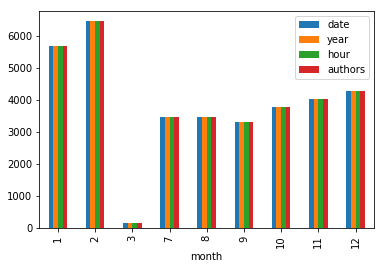

In [305]:
df_test.groupby(['month']).count().plot(kind='bar')

plt.show()

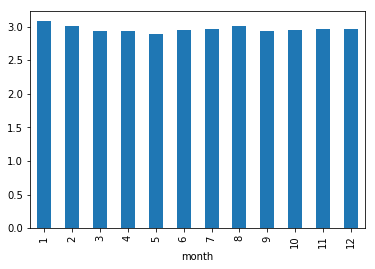

In [309]:
df[df["year"]>=2016].groupby(['month'])['y'].mean().plot(kind='bar')

plt.show()

In [57]:
X_train_year_hour = csr_matrix(hstack([X_train_year, 
                             pd.get_dummies(df["hour"])]))

In [58]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_year_hour_part = X_train_year_hour[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_year_hour_valid =  X_train_year_hour[train_part_size:, :]
y_valid = y_train[train_part_size:]

In [59]:
%%time
model.fit(X_train_year_hour_part, y_train_part)

Wall time: 3min 25s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [60]:
xgb_year_hour_pred = model.predict(X_year_hour_valid)

In [63]:
valid_mae = mean_absolute_error(y_valid, xgb_year_hour_pred)
valid_mae, np.expm1(valid_mae)

(1.2516975919662823, 2.496273167740513)

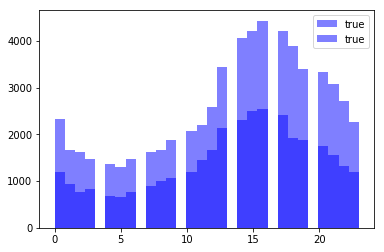

In [155]:
plt.hist(df_test["hour"], bins=30, alpha=.5, color='blue', label='true');
plt.hist(df["hour"], bins=30, alpha=.5, color='blue', label='true');
plt.legend();

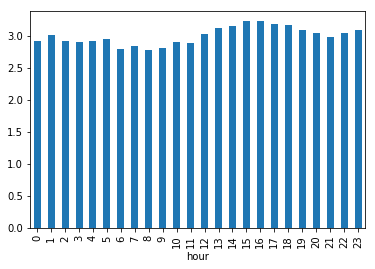

In [156]:
df.groupby(['hour'])['y'].mean().plot(kind='bar')

plt.show()

In [63]:
df["hour1518"]=df["hour"].apply(lambda t: int(t>=15 and t<=18))

In [169]:
df.head()

,date,y,year,hour,hour1518
0,2012-08-13 22:54:53.510,9.01201,2012,22,False
1,2015-08-03 07:44:50.331,3.49651,2015,7,False
2,2017-02-05 13:08:17.410,0.69315,2017,13,False
3,2017-05-06 08:16:30.776,1.38629,2017,8,False
4,2017-06-04 14:46:25.772,1.94591,2017,14,False


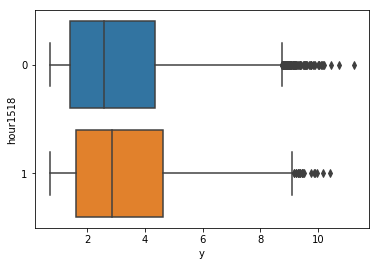

In [184]:
sns.boxplot(y="hour1518", x="y", data=df, orient="h")

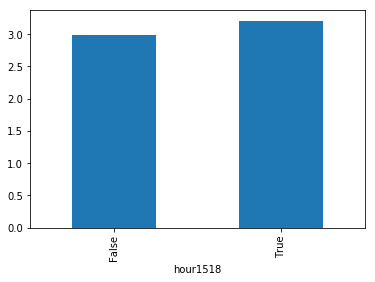

In [172]:
df.groupby(['hour1518'])['y'].mean().plot(kind='bar')

plt.show()

In [64]:
X_train_1518 = csr_matrix(hstack([X_train, 
                             df["hour1518"].values.reshape(-1,1)]))

In [186]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_1518_part = X_train_1518[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_train_1518_valid =  X_train_1518[train_part_size:, :]
y_valid = y_train[train_part_size:]

In [190]:
%%time
ridge.fit(X_train_1518_part, y_train_part)

Wall time: 3min 25s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [191]:
xgb_1518_pred = ridge.predict(X_train_1518_valid)

In [192]:
valid_mae = mean_absolute_error(y_valid, xgb_1518_pred)
valid_mae, np.expm1(valid_mae)

(1.3059524949251742, 2.691203272205299)

In [ ]:
1.2530238984294422, 2.5009133739273768)

In [ ]:
(1.3063010808364373, 2.6924901979506584)

In [65]:
def get_author(path_to_inp_json_file):
    output_list = []
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file:
        for line in tqdm_notebook(inp_file):
       #     print(line)
            json_data = read_json_line(line)
            content = json_data['author']['url']
          #  print(content)
            #content_no_html_tags = strip_tags(content)
            output_list.append(content)
           # return output_list
    return output_list;

In [199]:
def get_domain(path_to_inp_json_file):
    output_list = []
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file:
        for line in tqdm_notebook(inp_file):
       #     print(line)
            json_data = read_json_line(line)
            content = json_data['domain']
          #  print(content)
            #content_no_html_tags = strip_tags(content)
            output_list.append(content)
           # return output_list
    return output_list;

In [200]:
df["domain"] = get_domain((os.path.join(PATH_TO_DATA,'train.json')))

A Jupyter Widget

In [201]:
df_test["domain"] = get_domain((os.path.join(PATH_TO_DATA,'test.json')))

A Jupyter Widget

In [206]:
df_common["domain"] = df["domain"].append(df_test["domain"], ignore_index=True)

In [66]:
df["authors"] = get_author((os.path.join(PATH_TO_DATA,'train.json')))

A Jupyter Widget

In [67]:
df_test["authors"] = get_author((os.path.join(PATH_TO_DATA,'test.json')))

A Jupyter Widget

In [198]:
X_train_authors = csr_matrix(hstack([X_train, 
                             pd.get_dummies(df["authors"])]))

In [199]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_authors_part = X_train_authors[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_train_authors_valid =  X_train_authors[train_part_size:, :]
y_valid = y_train[train_part_size:]

In [200]:
%%time
model.fit(X_train_authors_part, y_train_part)

Wall time: 3min 31s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [201]:
xgb_authors_pred = model.predict(X_train_authors_valid)

In [202]:
valid_mae = mean_absolute_error(y_valid, xgb_authors_pred)
valid_mae, np.expm1(valid_mae)

(1.2525936909703166, 2.4994075788055317)

In [68]:
df_common["authors"] = df["authors"].append(df_test["authors"], ignore_index=True)

In [222]:
df_test["authors"].tail()

34640      https://medium.com/@lilykherman
34641    https://medium.com/@ivan_gabriele
34642      https://medium.com/@NickTroiano
34643      https://medium.com/@sharrieff__
34644            https://medium.com/@i6mi6
Name: authors, dtype: object

In [223]:
df_common["authors"].tail()

96953      https://medium.com/@lilykherman
96954    https://medium.com/@ivan_gabriele
96955      https://medium.com/@NickTroiano
96956      https://medium.com/@sharrieff__
96957            https://medium.com/@i6mi6
Name: authors, dtype: object

In [ ]:
df_common = pd.DataFrame(
    {'date': dates_train+dates_test
    })

In [69]:
X_train_authors = csr_matrix(hstack([X_train, 
                             (pd.get_dummies(df_common["authors"]))[:df.shape[0]]]))

In [70]:
X_test_authors = csr_matrix(hstack([X_test, 
                             (pd.get_dummies(df_common["authors"]))[df.shape[0]:]]))

In [234]:
%%time
model.fit(X_train_authors, y_train)

Wall time: 5min 52s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [235]:
xgb_test_authors_pred_40k = model.predict(X_test_authors)

In [236]:
write_submission_file(prediction=xgb_test_authors_pred_40k, 
                      filename='xgb_test_authors_pred_40k.csv')

In [79]:
from sklearn.feature_extraction.text import TfidfTransformer

In [237]:

tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train_tf = tf_transformer.transform(X_train)

In [238]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_tf_part = X_train_tf[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_train_tf_valid =  X_train_tf[train_part_size:, :]
y_valid = y_train[train_part_size:]

In [240]:
%%time
model.fit(X_train_tf_part, y_train_part)

Wall time: 11min 4s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [241]:
X_train_tf_valid_pred = model.predict(X_train_tf_valid)

In [242]:
valid_mae = mean_absolute_error(y_valid, X_train_tf_valid_pred)
valid_mae, np.expm1(valid_mae)

(1.2518122665834983, 2.4966741245170496)

In [80]:
tf_idf_transformer = TfidfTransformer(use_idf=True).fit(X_train)
X_train_tf_idf = tf_idf_transformer.transform(X_train)

In [81]:
X_test_tf_idf = tf_idf_transformer.transform(X_test)

In [244]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_tf_idf_part = X_train_tf_idf[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_train_tf_idf_valid =  X_train_tf_idf[train_part_size:, :]
y_valid = y_train[train_part_size:]

In [245]:
%%time
model.fit(X_train_tf_idf_part, y_train_part)

Wall time: 11min 7s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [82]:
X_train_tf_idf_valid_pred = model.predict(X_train_tf_idf_valid)

NameError: name 'model' is not defined

In [248]:
valid_mae = mean_absolute_error(y_valid, X_train_tf_idf_valid_pred)
valid_mae, np.expm1(valid_mae)

(1.2509367003781717, 2.4936138947349731)

In [252]:
%%time
model.fit(X_train_tf_idf, y_train)

Wall time: 15min 58s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [253]:
X_test_tf_idf_pred = model.predict(X_test_tf_idf)

In [254]:
write_submission_file(prediction=X_test_tf_idf_pred, 
                      filename='X_test_tf_idf_pred.csv')

In [255]:
test_tf_idf_transformer = TfidfTransformer(use_idf=True).fit(X_test)
X_test_tf_idf_own_transformer = test_tf_idf_transformer.transform(X_test)

In [270]:
X_test_tf_idf_pred = model.predict(X_test_tf_idf_own_transformer)

In [257]:
write_submission_file(prediction=X_test_tf_idf_pred, 
                      filename='X_test_tf_idf_pred_own_transformer.csv')

In [258]:
%%time
ridge.fit(X_train_tf_idf_part, y_train_part)

Wall time: 20.9 s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [259]:
rifge_tf_idf_pred = ridge.predict(X_train_tf_idf_valid)

In [260]:
valid_mae = mean_absolute_error(y_valid, rifge_tf_idf_pred)
valid_mae, np.expm1(valid_mae)

(1.1974721543354006, 2.311734778414531)

In [261]:
%%time
ridge.fit(X_train_tf_idf, y_train)

Wall time: 26.7 s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [262]:
ridge_X_test_tf_idf_own_transformer_pred = ridge.predict(X_test_tf_idf_own_transformer)

In [263]:
ridge_X_test_tf_idf_own_transformer_pred.mean()

3.1490052872928977

In [267]:
ridge_X_test_tf_idf_own_transformer_pred_h=ridge_X_test_tf_idf_own_transformer_pred*4.33328/ridge_X_test_tf_idf_own_transformer_pred.mean()

In [268]:
ridge_X_test_tf_idf_own_transformer_pred_h.mean()

4.3332800000000011

In [269]:
write_submission_file(prediction=ridge_X_test_tf_idf_own_transformer_pred_h, 
                      filename='ridge_X_test_tf_idf_own_transformer_pred_h.csv')

In [271]:
X_test_tf_idf_pred.mean()

3.1261098

In [272]:
X_test_tf_idf_pred_h=X_test_tf_idf_pred*4.3/X_test_tf_idf_pred.mean()

In [273]:
write_submission_file(prediction=X_test_tf_idf_pred_h, 
                      filename='xgb_X_test_tf_idf_pred_h.csv')

In [274]:
ridge_X_test_tf_idf_own_transformer_pred

array([ 3.37728843,  3.38669522,  4.09850621, ...,  3.07326856,
        3.9209705 ,  3.87096243])

In [275]:
X_test_tf_idf_pred

array([ 3.58420873,  3.32069039,  2.79835391, ...,  3.06104803,
        3.20294333,  3.73972344], dtype=float32)

In [276]:
ridge_X_test_tf_idf_own_transformer_pred_h

array([ 4.64741563,  4.66036012,  5.63986827, ...,  4.22906029,
        5.3955651 ,  5.32675005])

In [277]:
X_test_tf_idf_pred_h

array([ 4.93012047,  4.56764793,  3.8491683 , ...,  4.21050692,
        4.40568542,  5.14403296], dtype=float32)

In [83]:
X_train_authors_tf_idf = csr_matrix(hstack([X_train_tf_idf, 
                             (pd.get_dummies(df_common["authors"]))[:df.shape[0]]]))

In [84]:
X_test_authors_tf_idf = csr_matrix(hstack([X_test_tf_idf, 
                             (pd.get_dummies(df_common["authors"]))[df.shape[0]:]]))

In [385]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_authors_tf_idf_part = X_train_authors_tf_idf[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_train_authors_tf_idf_valid =  X_train_authors_tf_idf[train_part_size:, :]
y_valid = y_train[train_part_size:]

In [386]:
%%time
ridge.fit(X_train_authors_tf_idf_part, y_train_part)

Wall time: 29.2 s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [387]:
ridge_X_train_authors_tf_idf_valid_pred = ridge.predict(X_train_authors_tf_idf_valid)

In [388]:
valid_mae = mean_absolute_error(y_valid, ridge_X_train_authors_tf_idf_valid_pred)
valid_mae, np.expm1(valid_mae)

(1.1052991633759721, 2.0201278453133193)

In [ ]:
***

In [71]:
def get_minute_read(path_to_inp_json_file):
    output_list = []
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file:
        for line in tqdm_notebook(inp_file):
       #     print(line)
            json_data = read_json_line(line)
            content = int((json_data['meta_tags']['twitter:data1']).split()[0])
          #  print(content)
            #content_no_html_tags = strip_tags(content)
            output_list.append(content)
          #  return output_list
    return output_list

In [173]:
def get_title_read(path_to_inp_json_file):
    output_list = []
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file:
        for line in tqdm_notebook(inp_file):
       #     print(line)
            json_data = read_json_line(line)
            content = json_data['meta_tags']['title'].split('\u2013')[0].strip()
          #  print(content)
            #content_no_html_tags = strip_tags(content)
            output_list.append(content)
          #  return output_list
    return output_list

In [174]:
df['title']=get_title_read(os.path.join(PATH_TO_DATA,'train.json'))

A Jupyter Widget

In [175]:
df_test['title']=get_title_read(os.path.join(PATH_TO_DATA,'test.json'))

A Jupyter Widget

In [176]:
%%time
X_train_title = cv.fit_transform(df['title'])
X_test_title = cv.transform(df_test['title'])

Wall time: 3.5 s


In [72]:
df['read_minutes']=get_minute_read(os.path.join(PATH_TO_DATA,'train.json'))

A Jupyter Widget

In [73]:
df_test['read_minutes']=get_minute_read(os.path.join(PATH_TO_DATA,'test.json'))

A Jupyter Widget

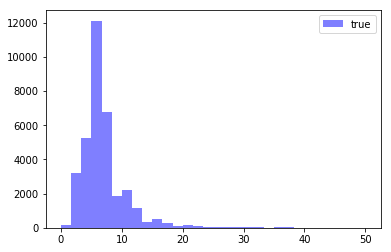

In [440]:
plt.hist(df_test['read_minutes'], bins=30, alpha=.5, color='blue', label='true', range=(0,50));
plt.legend();

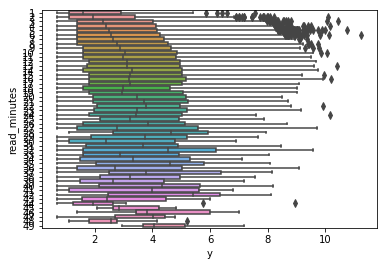

In [411]:
sns.boxplot(y="read_minutes", x="y", data=df[df['read_minutes']<50], orient="h")

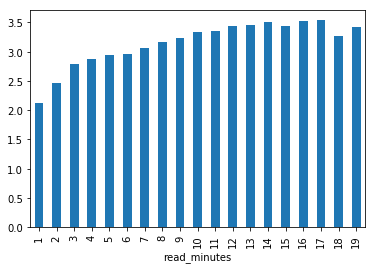

In [417]:
df[df['read_minutes']<20].groupby(['read_minutes'])['y'].mean().plot(kind='bar')

plt.show()

In [74]:
df['read_minutes2'] = df['read_minutes'].apply(lambda t: t if t<= 17 else 18)

In [75]:
df_test['read_minutes2'] = df_test['read_minutes'].apply(lambda t: t if t<= 17 else 18)

In [85]:
X_train_authors_tf_idf_read_minutes2 = csr_matrix(hstack([X_train_authors_tf_idf, 
                             df['read_minutes2'].values.reshape(-1, 1)                                                     ]
                                                    ))

In [86]:
X_test_authors_tf_idf_read_minutes2 = csr_matrix(hstack([X_test_authors_tf_idf, 
                             df_test['read_minutes2'].values.reshape(-1, 1)                                                     ]
                                                    ))

In [424]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_authors_tf_idf_read_minutes2_part = X_train_authors_tf_idf_read_minutes2[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_train_authors_tf_idf_read_minutes2_valid =  X_train_authors_tf_idf_read_minutes2[train_part_size:, :]
y_valid = y_train[train_part_size:]

In [425]:
%%time
ridge.fit(X_train_authors_tf_idf_read_minutes2_part, y_train_part)

Wall time: 2min 19s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [427]:
ridge_X_train_authors_tf_idf_read_minutes2_valid_pred = ridge.predict(X_train_authors_tf_idf_read_minutes2_valid)

In [428]:
valid_mae = mean_absolute_error(y_valid, ridge_X_train_authors_tf_idf_read_minutes2_valid_pred)
valid_mae, np.expm1(valid_mae)

(1.0961663589217789, 1.9926711773074897)

In [251]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [252]:
scaler.fit(df['image_size'].values.reshape(-1, 1))
df['image_size_scaled'] = scaler.transform(df['image_size'].values.reshape(-1, 1))

In [254]:
df_test['image_size_scaled'] = scaler.transform(df_test['image_size'].values.reshape(-1, 1))

In [88]:
scaler.fit(df['read_minutes2'].values.reshape(-1, 1))
df['read_minutes2_scaled'] = scaler.transform(df['read_minutes2'].values.reshape(-1, 1))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [89]:
df_test['read_minutes2_scaled'] = scaler.transform(df_test['read_minutes2'].values.reshape(-1, 1))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [90]:
X_train_authors_tf_idf_read_minutes2_scaled = csr_matrix(hstack([X_train_authors_tf_idf, 
                             df['read_minutes2_scaled'].values.reshape(-1, 1)                                                     ]
                                                    ))

In [91]:
X_test_authors_tf_idf_read_minutes2_scaled = csr_matrix(hstack([X_test_authors_tf_idf, 
                             df_test['read_minutes2_scaled'].values.reshape(-1, 1)                                                     ]
                                                    ))

In [433]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_authors_tf_idf_read_minutes2_scaled_part = X_train_authors_tf_idf_read_minutes2_scaled[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_train_authors_tf_idf_read_minutes2_scaled_valid =  X_train_authors_tf_idf_read_minutes2_scaled[train_part_size:, :]
y_valid = y_train[train_part_size:]

In [434]:
%%time
ridge.fit(X_train_authors_tf_idf_read_minutes2_scaled_part, y_train_part)

Wall time: 24.7 s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [435]:
ridge_X_train_authors_tf_idf_read_minutes2_scaled_valid_pred = ridge.predict(X_train_authors_tf_idf_read_minutes2_scaled_valid)

In [436]:
valid_mae = mean_absolute_error(y_valid, ridge_X_train_authors_tf_idf_read_minutes2_scaled_valid_pred)
valid_mae, np.expm1(valid_mae)

(1.0973157846837369, 1.9961130083414456)

In [443]:
%%time
ridge.fit(X_train_authors_tf_idf_read_minutes2, y_train)

Wall time: 3min 40s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [444]:
ridge_X_test_authors_tf_idf_read_minutes2_pred = ridge.predict(X_test_authors_tf_idf_read_minutes2)

In [445]:
ridge_X_test_authors_tf_idf_read_minutes2_pred_h=ridge_X_test_authors_tf_idf_read_minutes2_pred*4.33/ridge_X_test_authors_tf_idf_read_minutes2_pred.mean()

In [447]:
ridge_X_test_authors_tf_idf_read_minutes2_pred_h.mean()

4.330000000000001

In [448]:
write_submission_file(prediction=ridge_X_test_authors_tf_idf_read_minutes2_pred_h, 
                      filename='ridge_X_test_authors_tf_idf_read_minutes2_pred_h.2.csv')

In [454]:
'https://medium.com/policy/medium-terms-of-service-9db0094a1e0f'[len('https://medium.com/'):]

'policy/medium-terms-of-service-9db0094a1e0f'

In [452]:
len('https://medium.com/')

19

In [457]:
'https://medium.com/policy/medium-terms-of-service-9db0094a1e0f'.split('/')[3]

'policy'

In [285]:
%%time
ridge.fit(X_train_authors_tf_idf, y_train)

Wall time: 36.4 s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [286]:
ridge_X_test_authors_tf_idf_pred = ridge.predict(X_test_authors_tf_idf)

In [287]:
ridge_X_test_authors_tf_idf_pred_h=ridge_X_test_authors_tf_idf_pred*4.33/ridge_X_test_authors_tf_idf_pred.mean()

In [290]:
ridge_X_test_authors_tf_idf_pred_h.mean()

4.3300000000000001

In [291]:
write_submission_file(prediction=ridge_X_test_authors_tf_idf_pred_h, 
                      filename='ridge_X_test_authors_tf_idf_pred_h.csv')

In [92]:
df['y2017h12-23'] = df['date'].apply(lambda ts: ts.year >=2017 and ts.hour>11)
df['y2017dw3-6'] = df['date'].apply(lambda ts: ts.year >=2017 and ts.weekday()>2)

In [93]:
df_test['y2017h0-11'] = df_test['date'].apply(lambda ts: ts.year >=2017 and ts.hour<=11)
df_test['y2017dw0-2'] = df_test['date'].apply(lambda ts: ts.year >=2017 and ts.weekday()<=2)
df_test['y2017h12-23'] = df_test['date'].apply(lambda ts: ts.year >=2017 and ts.hour>11)
df_test['y2017dw3-6'] = df_test['date'].apply(lambda ts: ts.year >=2017 and ts.weekday()>2)

In [94]:
X_train_authors_tf_idf_3datefeat = csr_matrix(hstack([X_train_authors_tf_idf, 
                             df['y2017h0-11'].values.reshape(-1, 1)
                             ,df['y2017dw0-2'].values.reshape(-1, 1)
                            ,df['y2017h12-23'].values.reshape(-1, 1)
                             ,df['y2017dw3-6'].values.reshape(-1, 1)

                         #    df['day_of_week0-2'].values.reshape(-1, 1),
                         #    df['h0-11'].values.reshape(-1, 1)
                                                     ]
                                                    ))

In [95]:
X_test_authors_tf_idf_3datefeat = csr_matrix(hstack([X_test_authors_tf_idf, 
                             df_test['y2017h0-11'].values.reshape(-1, 1)
                             ,df_test['y2017dw0-2'].values.reshape(-1, 1)
                            ,df_test['y2017h12-23'].values.reshape(-1, 1)
                             ,df_test['y2017dw3-6'].values.reshape(-1, 1)

                         #    df['day_of_week0-2'].values.reshape(-1, 1),
                         #    df['h0-11'].values.reshape(-1, 1)
                                                     ]
                                                    ))

In [368]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_authors_tf_idf_3datefeat_part = X_train_authors_tf_idf_3datefeat[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_train_authors_tf_idf_3datefeat_valid =  X_train_authors_tf_idf_3datefeat[train_part_size:, :]
y_valid = y_train[train_part_size:]

In [369]:
%%time
ridge.fit(X_train_authors_tf_idf_3datefeat_part, y_train_part)

Wall time: 25.5 s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [370]:
ridge_X_train_authors_tf_idf_3datefeat_valid_pred = ridge.predict(X_train_authors_tf_idf_3datefeat_valid)

In [371]:
valid_mae = mean_absolute_error(y_valid, ridge_X_train_authors_tf_idf_3datefeat_valid_pred)
valid_mae, np.expm1(valid_mae)

(1.1072052954812699, 2.0258900980241354)

In [374]:
%%time
ridge.fit(X_train_authors_tf_idf_3datefeat, y_train)

Wall time: 42.6 s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [375]:
ridge_X_test_authors_tf_idf_3datefeat_pred = ridge.predict(X_test_authors_tf_idf_3datefeat)

In [376]:
ridge_X_test_authors_tf_idf_3datefeat_pred_h=ridge_X_test_authors_tf_idf_3datefeat_pred*4.2/ridge_X_test_authors_tf_idf_3datefeat_pred.mean()

In [377]:
write_submission_file(prediction=ridge_X_test_authors_tf_idf_3datefeat_pred_h, 
                      filename='ridge_X_test_authors_tf_idf_3datefeat_pred_h4.2.csv')

In [247]:
def get_image_size(path_to_inp_json_file):
    output_list = []
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file:
        for line in tqdm_notebook(inp_file):
       #     print(line)
            json_data = read_json_line(line)
           # print(json_data['image_url'])
            content = 0
            if json_data['image_url']:
                content = int((json_data['image_url']).split('/')[4])
          #  print(content)
            #content_no_html_tags = strip_tags(content)
            output_list.append(content)
          #  return output_list
    return output_list

In [248]:
df['image_size']=get_image_size(os.path.join(PATH_TO_DATA,'train.json'))

A Jupyter Widget

In [250]:
df_test['image_size']=get_image_size(os.path.join(PATH_TO_DATA,'test.json'))

A Jupyter Widget

In [249]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62313 entries, 0 to 62312
Data columns (total 22 columns):
date                    62313 non-null datetime64[ns]
y                       62313 non-null float64
year                    62313 non-null int64
hour                    62313 non-null int64
day_of_week             62313 non-null int64
y2017                   62313 non-null bool
day_of_week0-2          62313 non-null bool
h0-11                   62313 non-null bool
y2017h0-11              62313 non-null bool
y2017dw0-2              62313 non-null bool
month                   62313 non-null int64
hour1518                62313 non-null int64
authors                 62313 non-null object
read_minutes            62313 non-null int64
read_minutes2           62313 non-null int64
read_minutes2_scaled    62313 non-null float64
y2017h12-23             62313 non-null bool
y2017dw3-6              62313 non-null bool
section                 62313 non-null object
title                   6231

In [96]:
def get_section(path_to_inp_json_file):
    output_list = []
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file:
        for line in tqdm_notebook(inp_file):
       #     print(line)
            json_data = read_json_line(line)
            content = ((json_data['_id']).split('/')[3])
          #  print(content)
            #content_no_html_tags = strip_tags(content)
            output_list.append(content)
          #  return output_list
    return output_list

In [97]:
df['section']=get_section(os.path.join(PATH_TO_DATA,'train.json'))

A Jupyter Widget

In [98]:
df_test['section']=get_section(os.path.join(PATH_TO_DATA,'test.json'))

A Jupyter Widget

In [470]:
df[df['section'].isin(df['section'].value_counts().head(20).keys())]

,date,y,year,hour,hour1518,authors,day_of_week,month,y2017,day_of_week0-2,h0-11,y2017h0-11,y2017dw0-2,y2017h12-23,y2017dw3-6,read_minutes,read_minutes2,read_minutes2_scaled,section
9,2015-10-25 02:58:05.551,8.64840,2015,2,0,https://medium.com/@RaghavHaran,6,10,False,False,True,False,False,False,False,8,8,0.289053,the-mission
56,2017-04-04 16:02:16.587,7.09091,2017,16,1,https://medium.com/@alltopstartups,1,4,True,True,False,False,True,True,False,5,5,-0.570725,personal-growth
58,2014-10-08 04:06:36.120,9.71118,2014,4,0,https://medium.com/@readmatter,2,10,False,True,True,False,False,False,False,27,18,3.154980,matter
61,2016-07-28 13:56:19.024,5.77144,2016,13,0,https://medium.com/@kvlehr,3,7,False,False,False,False,False,False,False,5,5,-0.570725,matter
62,2016-08-04 15:09:22.089,3.82864,2016,15,1,https://medium.com/@ankurthakkar,3,8,False,False,False,False,False,False,False,2,2,-1.430503,matter
64,2014-11-11 13:58:54.551,7.37838,2014,13,0,https://medium.com/@jennydeluxe,1,11,False,True,False,False,False,False,False,16,16,2.581794,matter
80,2016-04-09 02:08:39.102,8.59434,2016,2,0,https://medium.com/@danieleckler,5,4,False,False,True,False,False,False,False,6,6,-0.284132,swlh
90,2016-09-28 13:01:03.369,6.53088,2016,13,0,https://medium.com/@jessiwrites,2,9,False,True,False,False,False,False,False,10,10,0.862239,backchannel
109,2017-04-14 21:53:34.176,7.17089,2017,21,0,https://medium.com/@benjaminhardy,4,4,True,False,False,False,False,True,True,4,4,-0.857317,the-mission
129,2017-04-22 19:08:54.818,6.14633,2017,19,0,https://medium.com/@stevenlevy,5,4,True,False,False,False,False,True,True,6,6,-0.284132,backchannel


In [99]:
df_common["section"] = df["section"].append(df_test["section"], ignore_index=True)

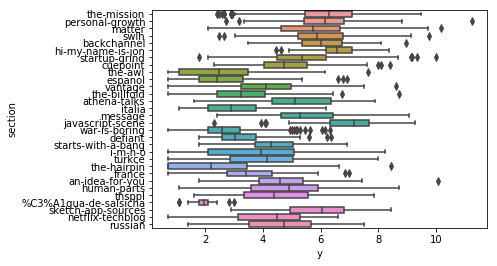

In [473]:
sns.boxplot(y="section", x="y", data=df[df['section'].isin(df['section'].value_counts().head(30).keys())], orient="h")

In [474]:
1+1

2

In [100]:
X_train_authors_tf_idf_read_minutes2_scaled_section = csr_matrix(hstack([X_train_authors_tf_idf_read_minutes2_scaled, 
                             (pd.get_dummies(df_common["section"]))[:df.shape[0]]]))

In [101]:
X_test_authors_tf_idf_read_minutes2_scaled_section = csr_matrix(hstack([X_test_authors_tf_idf_read_minutes2_scaled, 
                             (pd.get_dummies(df_common["section"]))[df.shape[0]:]]))

In [102]:
%%time
ridge.fit(X_train_authors_tf_idf_read_minutes2_scaled_section, y_train)

Wall time: 44.4 s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [103]:
ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred = ridge.predict(X_test_authors_tf_idf_read_minutes2_scaled_section)

In [104]:
ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred.mean()

3.1679249565843337

In [109]:
ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_h=\
ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred+(4.33328-3.1679249565843337)

In [ ]:
(4.33328-3.1679249565843337)/34645

In [105]:
len(ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred)

34645

In [110]:
ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_h.mean()

4.3332800000000011

In [111]:
write_submission_file(prediction=ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_h, 
                      filename='ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_h_summ.csv')

In [114]:
ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log = list(map(to_log_value, ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred))

In [116]:
ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log_hsum=\
ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log+(4.33328-np.mean(ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log))

In [118]:
write_submission_file(prediction=ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log_hsum, 
                      filename='ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log_hsum.csv')

In [117]:
np.mean(ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log_hsum)

4.3332800000000002

In [207]:
X_train_domain = csr_matrix(hstack([X_train_authors_tf_idf_read_minutes2_scaled_section, 
                             (pd.get_dummies(df_common["domain"]))[:df.shape[0]]]))

In [208]:
X_test_domain = csr_matrix(hstack([X_test_authors_tf_idf_read_minutes2_scaled_section, 
                             (pd.get_dummies(df_common["domain"]))[df.shape[0]:]]))

In [209]:
%%time
ridge.fit(X_train_domain, y_train)

Wall time: 52.1 s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [210]:
X_test_domain_pred = ridge.predict(X_test_domain)

In [211]:
X_test_domain_pred.mean()

3.1921789359452051

In [212]:
X_test_domain_pred_log = list(map(to_log_value, X_test_domain_pred))

In [213]:
X_test_domain_pred_log_hsum=\
X_test_domain_pred_log+(4.33328-np.mean(X_test_domain_pred_log))

In [214]:
write_submission_file(prediction=X_test_domain_pred_log_hsum, 
                      filename='X_test_domain_pred_log_hsum.csv')

In [215]:
X_test_domain_pred_log_hsum_log = list(map(to_log_value, X_test_domain_pred_log_hsum))

In [216]:
np.mean(X_test_domain_pred_log_hsum_log)

4.3341698958002599

In [217]:
write_submission_file(prediction=X_test_domain_pred_log_hsum_log, 
                      filename='X_test_domain_pred_log_hsum_log.csv')

In [255]:
X_train_domain_image = csr_matrix(hstack([X_train_domain, 
                             df['image_size_scaled'].values.reshape(-1, 1)                                                     ]
                                                    ))

In [256]:
X_test_domain_image = csr_matrix(hstack([X_test_domain, 
                             df_test['image_size_scaled'].values.reshape(-1, 1)                                                     ]
                                                    ))

In [257]:
%%time
ridge.fit(X_train_domain_image, y_train)

Wall time: 1min 5s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [258]:
X_test_domain_image_pred = ridge.predict(X_test_domain_image)

In [259]:
X_test_domain_image_pred.mean()

3.2000252860277145

In [260]:
X_test_domain_image_pred_log = list(map(to_log_value, X_test_domain_image_pred))

In [261]:
X_test_domain_image_pred_log_hsum=\
X_test_domain_image_pred_log+(4.33328-np.mean(X_test_domain_image_pred_log))

In [262]:
X_test_domain_image_pred_log_hsum.mean()

4.3332800000000002

In [263]:
write_submission_file(prediction=X_test_domain_image_pred_log_hsum, 
                      filename='X_test_domain_image_pred_log_hsum.csv')

In [264]:
X_test_domain_image_pred_hsum=\
X_test_domain_image_pred+(4.33328-np.mean(X_test_domain_image_pred))

In [265]:
write_submission_file(prediction=X_test_domain_image_pred_hsum, 
                      filename='X_test_domain_image_pred_hsum.csv')

In [186]:
X_title = csr_matrix(hstack([X_train_authors_tf_idf_read_minutes2_scaled_section,
                             X_train_title_tf_idf]))

In [187]:
X_title_test = csr_matrix(hstack([X_test_authors_tf_idf_read_minutes2_scaled_section,
                             X_test_title_tf_idf]))

In [188]:
%%time
ridge.fit(X_title, y_train)

Wall time: 43 s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [189]:
X_title_test_pred = ridge.predict(X_title_test)

In [190]:
X_title_test_pred.mean()

3.1788060432977865

In [195]:
X_title_test_pred_log = list(map(to_log_value, X_title_test_pred))

In [196]:
np.mean(X_title_test_pred_log)

3.1798394839082116

In [194]:
np.mean(X_title_test_pred_log2)

3.1798394839082116

In [197]:
X_title_test_pred_log_hsum=\
X_title_test_pred_log+(4.33328-np.mean(X_title_test_pred_log))

In [198]:
write_submission_file(prediction=X_title_test_pred_log_hsum, 
                      filename='X_title_test_pred_log_hsum_tfidf.csv')

In [185]:
tf_idf_transformer = TfidfTransformer(use_idf=True).fit(X_train_title)
X_train_title_tf_idf = tf_idf_transformer.transform(X_train_title)
X_test_title_tf_idf = tf_idf_transformer.transform(X_test_title)

In [121]:
model = XGBRegressor()

In [122]:
%%time
model.fit(X_train_authors_tf_idf_read_minutes2_scaled_section, y_train)

Wall time: 17min 6s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [123]:
xgb_pred = model.predict(X_test_authors_tf_idf_read_minutes2_scaled_section)

In [124]:
xgb_pred_log = list(map(to_log_value, xgb_pred))

In [125]:
xgb_pred_log_hsum=\
xgb_pred_log+(4.33328-np.mean(xgb_pred_log))

In [126]:
write_submission_file(prediction=xgb_pred_log_hsum, 
                      filename='xgb_pred_log_hsum.csv')

In [127]:
%%time
ridge.fit(X_train_authors_tf_idf_read_minutes2_scaled_section, np.log1p(y_train))

Wall time: 39.2 s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [129]:
ridge_test_pred  = np.expm1(ridge.predict(X_test_authors_tf_idf_read_minutes2_scaled_section))

In [134]:
lgb_x_train = lgb.Dataset(X_train_authors_tf_idf_read_minutes2_scaled_section.astype(np.float32),
                          label=np.log1p(y_train))

In [133]:
import lightgbm as lgb

In [132]:
!pip install lightgbm

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [137]:
num_round = 50
bst_lgb = lgb.train(param, lgb_x_train, num_round)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:99: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [136]:
param = {'num_leaves': 31, 'num_trees': 100, 'objective': 'mean_absolute_error',
        'metric': 'mae'}

In [156]:
lgb_test_pred = np.expm1(bst_lgb.predict(X_test_authors_tf_idf_read_minutes2_scaled_section.astype(np.float32)))

In [162]:
mix_pred = .6 * lgb_test_pred + .4 * ridge_test_pred

In [163]:
np.mean(mix_pred)

2.8963098068193665

In [164]:
mix_pred_hsum=\
mix_pred+(4.33328-np.mean(mix_pred))

In [165]:
write_submission_file(prediction=mix_pred_hsum, 
                      filename='mix_pred_hsum_fix2.csv')

In [166]:
np.mean(mix_pred_hsum)

4.3332800000000002

In [167]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result

from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

def extract_features(path_to_data):
    
    content_list = [] 
    published_list = [] 
    title_list = []
    author_list = []
    domain_list = []
    tags_list = []
    url_list = []
    
    with open(path_to_data, encoding='utf-8') as inp_json_file:
        for line in inp_json_file:
            json_data = read_json_line(line)
            content = json_data['content'].replace('\n', ' ').replace('\r', ' ')
            content_no_html_tags = strip_tags(content)
            content_list.append(content_no_html_tags)
            published = json_data['published']['$date']
            published_list.append(published) 
            title = json_data['meta_tags']['title'].split('\u2013')[0].strip() #'Medium Terms of Service – Medium Policy – Medium'
            title_list.append(title) 
            author = json_data['meta_tags']['author'].strip()
            author_list.append(author) 
            domain = json_data['domain']
            domain_list.append(domain)
            url = json_data['url']
            url_list.append(url)
            
            tags_str = []
            soup = BeautifulSoup(content, 'lxml')
            try:
                tag_block = soup.find('ul', class_='tags')
                tags = tag_block.find_all('a')
                for tag in tags:
                    tags_str.append(tag.text.translate({ord(' '):None, ord('-'):None}))
                tags = ' '.join(tags_str)
            except Exception:
                tags = 'None'
            tags_list.append(tags)
            
    return content_list, published_list, title_list, author_list, domain_list, tags_list, url_list

In [172]:
content_list, published_list, title_list, author_list, domain_list, tags_list, url_list = extract_features(os.path.join(PATH_TO_DATA, 'train.json'))
train = pd.DataFrame()
train['content'] = content_list
train['published'] = pd.to_datetime(published_list, format='%Y-%m-%dT%H:%M:%S.%fZ')
train['title'] = title_list
train['author'] = author_list
train['domain'] = domain_list
train['tags'] = tags_list
train['length'] = train['content'].apply(len)
train['url'] = url_list

content_list, published_list, title_list, author_list, domain_list, tags_list, url_list = extract_features(os.path.join(PATH_TO_DATA, 'test.json'))
test = pd.DataFrame()
test['content'] = content_list
test['published'] = pd.to_datetime(published_list, format='%Y-%m-%dT%H:%M:%S.%fZ')
test['title'] = title_list
test['author'] = author_list
test['domain'] = domain_list
test['tags'] = tags_list
test['length'] = test['content'].apply(len)
test['url'] = url_list

train_target = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_log1p_recommends.csv'), index_col='id')
y_train = train_target['log_recommends'].values

del content_list, published_list, title_list, author_list, domain_list, tags_list, url_list
gc.collect()

KeyboardInterrupt: 

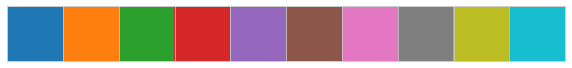

In [171]:
import numpy as np
import pandas as pd
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from scipy.sparse import csr_matrix, hstack
from scipy.stats import probplot
import pickle
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns 
import gc
import warnings
warnings.filterwarnings('ignore')
import time

color = sns.color_palette()
sns.set_style("whitegrid")
sns.set_context("paper")
sns.palplot(color)

import os

In [ ]:
1+2

In [ ]:
2+3

In [479]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_authors_tf_idf_read_minutes2_scaled_section_part = X_train_authors_tf_idf_read_minutes2_scaled_section[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_train_authors_tf_idf_read_minutes2_scaled_section_valid =  X_train_authors_tf_idf_read_minutes2_scaled_section[train_part_size:, :]
y_valid = y_train[train_part_size:]

In [480]:
%%time
ridge.fit(X_train_authors_tf_idf_read_minutes2_scaled_section_part, y_train_part)

Wall time: 30 s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [481]:
ridge_X_train_authors_tf_idf_read_minutes2_scaled_section_valid_pred = ridge.predict(X_train_authors_tf_idf_read_minutes2_scaled_section_valid)

In [482]:
valid_mae = mean_absolute_error(y_valid, ridge_X_train_authors_tf_idf_read_minutes2_scaled_section_valid_pred)
valid_mae, np.expm1(valid_mae)

(1.051199210427008, 1.8610800987044294)

In [487]:
%%time
ridge.fit(X_train_authors_tf_idf_read_minutes2_scaled_section, y_train)

Wall time: 38.8 s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [488]:
ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred = ridge.predict(X_test_authors_tf_idf_read_minutes2_scaled_section)

In [489]:
ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred.mean()

3.1679249565843337

In [490]:
X_test_domain_imageridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_h=ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred*4.33/ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred.mean()

In [491]:
ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_h.mean()

4.330000000000001

In [492]:
write_submission_file(prediction=ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_h, 
                      filename='ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_h433.csv')

In [113]:
def to_log_value(item):
    if item < np.log(2).round(5):
        return np.log(2).round(5);
    return np.log(np.round(np.exp(item))).round(5)

In [500]:
ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_h_log = list(map(to_log_value, ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_h))

In [503]:
ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_h.mean()

4.330000000000001

In [499]:
to_log_value(-0.97144652784325225)

0.69314718055994529

In [502]:
np.mean(ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_h_log)

4.330287835333591

In [504]:
write_submission_file(prediction=ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_h_log, 
                      filename='X_tfidf_5_date_feat.csv')

In [505]:
ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_h2=ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred*4.32/ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred.mean()

In [506]:
ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_h2_log = list(map(to_log_value, ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_h2))

In [507]:
ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_h2.mean()

4.3200000000000003

In [508]:
np.mean(ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_h2_log)

4.3203208454619242

In [509]:
write_submission_file(prediction=ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_h2_log, 
                      filename='ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_h432_log.csv')

In [510]:
ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_h435=ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred*4.35/ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred.mean()

In [511]:
ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_h435_log = list(map(to_log_value, ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_h435))

In [512]:
write_submission_file(prediction=ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_h435_log, 
                      filename='X_tfidf_5_date_feat_regularized.csv')

In [513]:
ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred.mean()

3.1679249565843337

In [514]:
ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred.min()

-0.71073203222675208

In [589]:
ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log = list(map(to_log_value, ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred))

In [596]:
np.mean(ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log)

3.1682998686679174

In [603]:
ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log_t=list(map(lambda t: t if t <=np.log(2).round(5) else t*4.34/3.1682998686679174,ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log))

In [604]:
np.mean(ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log_t)

4.3373807308778405

In [605]:
write_submission_file(prediction=ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log_t, 
                      filename='ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log_t2.csv')

In [572]:
(4.33-np.mean(ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log))*len(ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log)

40247.105224447019

In [574]:
40247.105224447019/len(matches)

1.4148101811947489

In [593]:
matches = list(x for x in ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log if x > np.log(2).round(5))

In [594]:
len(matches)

34291

In [600]:
np.mean(matches)

3.1938518517978474

In [590]:
len(ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log)

34645

In [582]:
np.log(2).round(5)

0.69315000000000004

In [581]:
y_train.min()

0.69315000000000004

In [533]:
(4.33-3.168299748175869)/3.168299748175869

0.36666361902562206

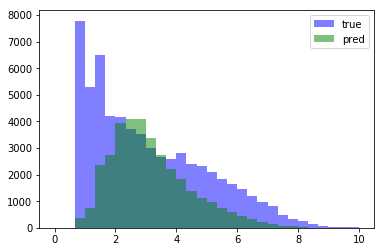

In [561]:
plt.hist(y_train, bins=30, alpha=.5, color='blue', label='true', range=(0,10));
#plt.hist(df[df["year"]<2017]["y"], bins=30, alpha=.5, color='green', label='pred', range=(0,10));

plt.hist(ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log, bins=30, alpha=.5, color='green', label='pred', range=(0,10));
plt.legend();

In [609]:
np.mean(ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log)

3.1682998686679174

In [608]:
np.max(y_train)

11.251569999999999

In [612]:
np.sum(ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log)

109765.74894999999

In [613]:
(4.33-3.168299748175869)*len(ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log)

40247.10522444702

In [614]:
ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log_t=list(map(lambda t: t+t*40247.10522444702/109765.74894999999 ,ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log))

In [616]:
np.mean(ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log_t)

4.3300001204920493

In [617]:
np.min(ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log_t)

0.94730287786204692

In [620]:
np.log(2).round(5)*4.33/3.1682998686679174

0.94730285150120153

In [631]:
ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log_t=list(map(lambda t: t+40247.10522444702*((t/109765.74894999999)**1.1) ,ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log))

In [622]:
5**2

25

In [632]:
np.mean(ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log_t)

3.580472023409313

In [633]:
sum_t_delta=list(map(lambda t: 40247.10522444702*((t/109765.74894999999)**1.1) ,ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log))

In [635]:
(40247.10522444702-np.sum(sum_t_delta))/len(ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log)

0.74952809708273527

In [636]:
4.33-3.580472023409313

0.749527976590687

In [637]:
ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log_t=list(map(lambda t: t*4.33/3.580472023409313 ,ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log_t))

In [638]:
np.mean(ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log_t)

4.330000000000001

In [639]:
np.min(ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log_t)

0.93108039848007051

In [640]:
ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log_t_log = list(map(to_log_value, ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log_t))

In [641]:
np.mean(ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log_t_log)

4.3317052275941688

In [642]:
write_submission_file(prediction=ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log_t_log, 
                      filename='ridge_X_test_authors_tf_idf_read_minutes2_scaled_section_pred_log_t_log.csv')